# Aim
Generate 88 20 node graphs, 8 for each even degree node count, with diff degrees

Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

#################
# My notebook issues
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
sys.path.append('home/egupta/.local/bin')

##############

import os
import numpy as np
import scipy.stats as ss
import networkx as nx
import csv 
import numpy as np
import seaborn as sns
from scipy.optimize import curve_fit
import scipy
import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline


##qtensor imports
import qtensor
from qtensor import QAOA_energy
from qtensor import parameter_optimization as popt
import torch

2021-09-18 05:11:36,100- WARNING•	QuickBB solver is unavailable
2021-09-18 05:11:36,102- WARNING•	Tamaki solver is unavailable: No path /home/egupta/.local/lib/python3.7/site-packages/thirdparty/tamaki_treewidth


#### Important Functions

In [11]:
def get_qaoa_params(graph, edge=None, gamma=[0.5], beta=[0.5], steps=50):
    loss_history, params_history = popt.qaoa_maxcut_torch(graph, gamma, beta,
                                                          ordering_algo='greedy',
                                                          Opt=torch.optim.RMSprop,
                                                          edge=edge,
                                                          opt_kwargs=dict(lr=0.002),
                                                          steps=steps,
                                                          pbar=False)
    best_ix = np.argmin(loss_history)
    return params_history[best_ix], loss_history[best_ix]

def get_edge_contribution(graph, edge, gamma, beta):
    sim = qtensor.QtreeSimulator()
    composer = qtensor.DefaultQAOAComposer(graph, gamma=gamma, beta=beta)
    composer.energy_expectation_lightcone(edge)
    return np.real(sim.simulate_batch(composer.circuit)[0])



def opt_runs(G, seeds = 20, steps = 200):
  """
  Doing multiple optimization runs, each with random initialized param
  Returning results which inlclude the optimal param and corresponding energies
  """

  #first do 20 optimization runs 
  s = 0
  g_results = []

  while s<seeds:
    print('seed #' + str(s))
    #initialize param
    gamma = [np.random.rand()]
    beta = [np.random.rand() ]
    initial_energy = QAOA_energy(G,gamma =  gamma, beta = beta)

    #optimization
    params, loss = get_qaoa_params(G, gamma=gamma, beta=beta,edge = None, steps=steps)
    #print('Finished get_qaoa_params')
    gamma_opt, beta_opt = params[0], params[1]
    opt_energy = QAOA_energy(G, gamma = gamma_opt, beta = beta_opt)

    result = np.asarray([float(gamma_opt), float(beta_opt), float(opt_energy), float(initial_energy)])
    g_results.append(result)
    s+=1

  
  return g_results

#### Import Old Graphs

In [12]:
file3 = open("110_20_node_graphs.txt")
mat_list = np.loadtxt(file3).reshape(110,20,20)

def mats_to_graphs(mat_list):
  """
  Given list of adjaceny matrix repr of graphs, converts to actual graphs
  """
  g_list = []
  for mat in mat_list:
    arr = np.array(mat)
    G = nx.convert_matrix.from_numpy_matrix(arr)
    g_list.append(G)
  return g_list

g_list = mats_to_graphs(mat_list)

Getting all the degree sequences

In [13]:
old_deg_seqs = []
for g in g_list:
    deg_seq = [d for n, d in g.degree()] 
    if deg_seq not in old_deg_seqs:
        old_deg_seqs.append(deg_seq)

In [14]:
len(old_deg_seqs)

22

# Create Graphs

In [15]:
import random
def generate_deg_seq(even_nodes, total_nodes, old_deg_seqs = old_deg_seqs):
  """
  Generates a degree sequence with specified number of even degree nodes
  Highest degree = 6
  lowest degree = 1
  """
  even = [2,4,6]
  odd = [1,3,5]
  deg_seq = []
 
  for i in range(1, total_nodes+1):
    if i<= even_nodes:
      deg = random.choice(even)
      deg_seq.append(deg)
    else:
      deg = random.choice(odd)
      deg_seq.append(deg)
    
  if deg_seq in old_deg_seqs:
      return generate_deg_seq(even_nodes, total_nodes)
  else:
      return deg_seq

In [16]:
def generate_random_graph(deg_seq, n_g_list, old_g_list = g_list):
  """
  Generates a random graph with specified deg seq
  """
  g = nx.random_degree_sequence_graph(deg_seq)
  if (not nx.is_connected(g)) or (is_isomorphic_to_old(g, n_g_list+old_g_list)):
    return generate_random_graph(deg_seq, n_g_list)
  return g

In [17]:
def is_isomorphic_to_old(graph,g_list):
  """
  Checks if graph is iso.. to graphs already in csv file
  """
  for i in g_list:
    if nx.is_isomorphic(graph, i):
      return True
  return False

generating deg seqs and graphs

In [18]:
even_nodes = [0+2*i for i in range(11)]
new_deg_seqs = []
n_g_list = []

for n in even_nodes:
    print('###################')
    print(n)
    for  i in range(8):
        print(i)
        deg_seq = generate_deg_seq(even_nodes = n, total_nodes = 20,old_deg_seqs = old_deg_seqs)
        old_deg_seqs.append(deg_seq)
        new_deg_seqs.append(deg_seq)
        g = generate_random_graph(deg_seq, n_g_list)
        n_g_list.append(g)

###################
0
0
1
2
3
4
5
6
7
###################
2
0
1
2
3
4
5
6
7
###################
4
0
1
2
3
4
5
6
7
###################
6
0
1
2
3
4
5
6
7
###################
8
0
1
2
3
4
5
6
7
###################
10
0
1
2
3
4
5
6
7
###################
12
0
1
2
3
4
5
6
7
###################
14
0
1
2
3
4
5
6
7
###################
16
0
1
2
3
4
5
6
7
###################
18
0
1
2
3
4
5
6
7
###################
20
0
1
2
3
4
5
6
7


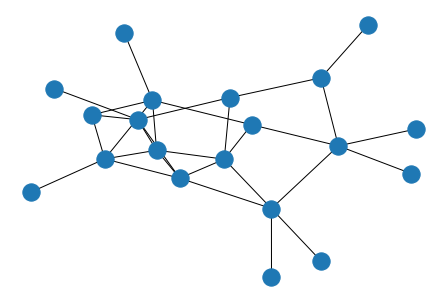

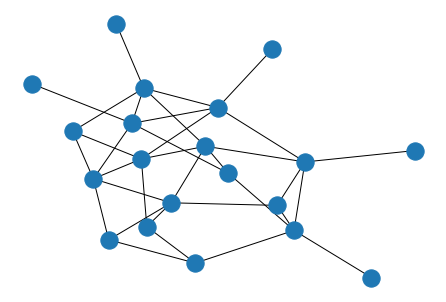

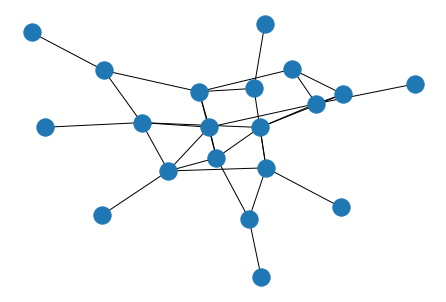

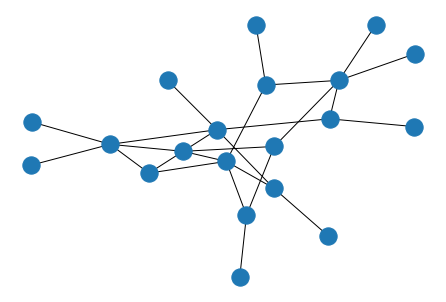

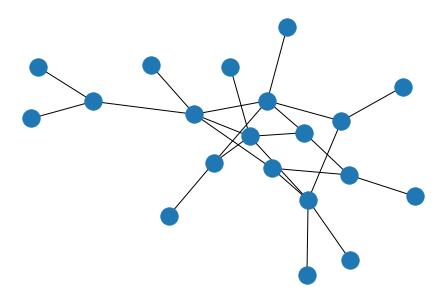

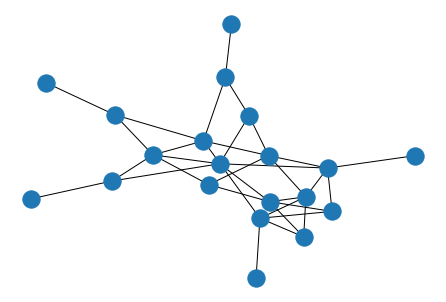

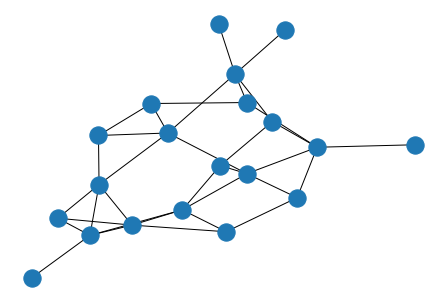

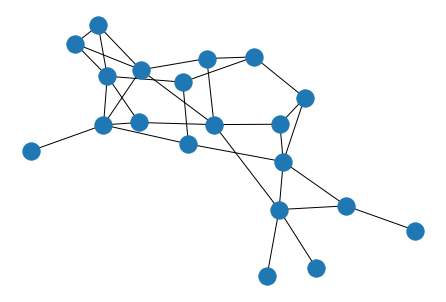

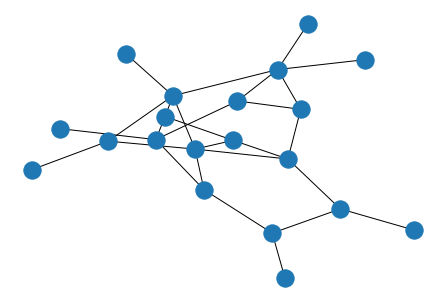

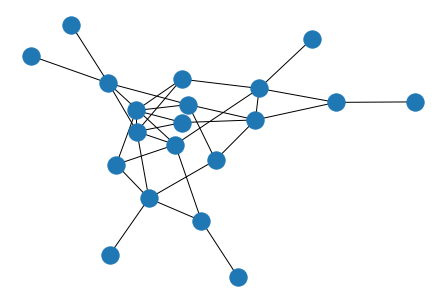

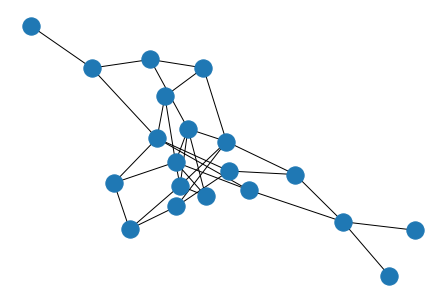

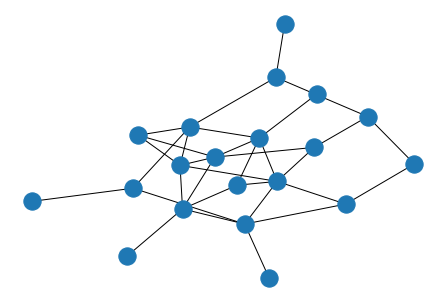

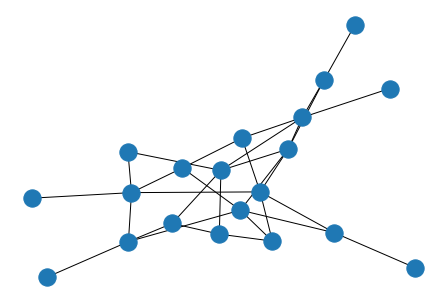

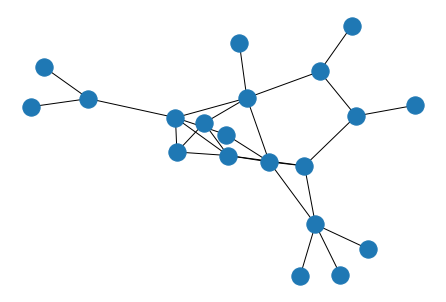

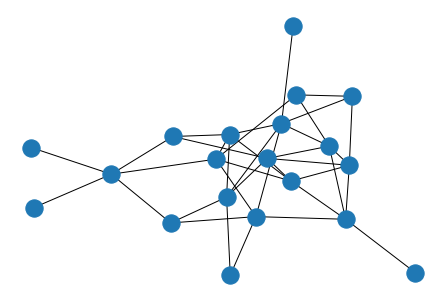

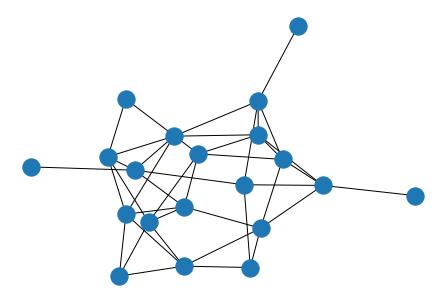

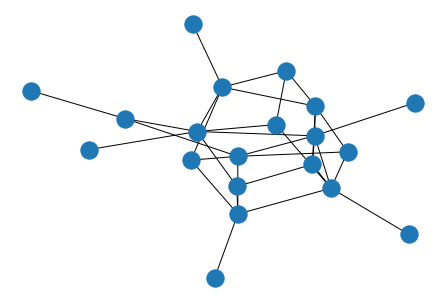

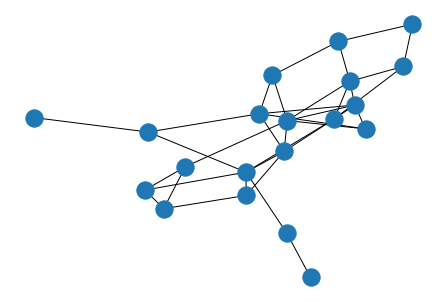

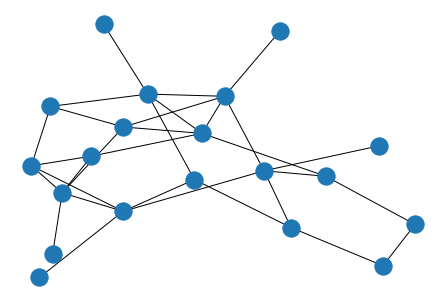

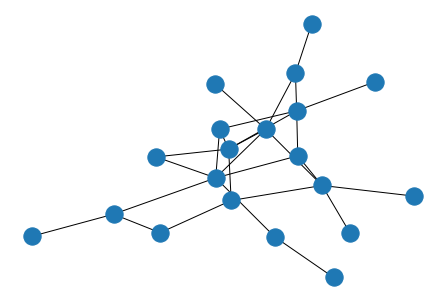

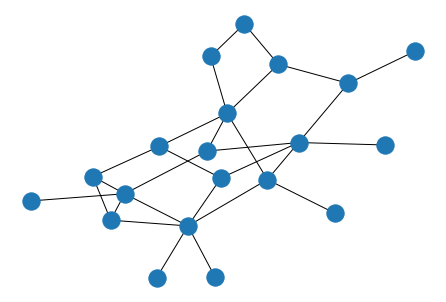

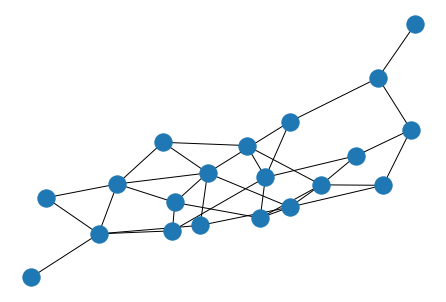

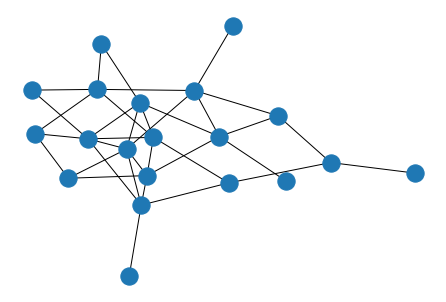

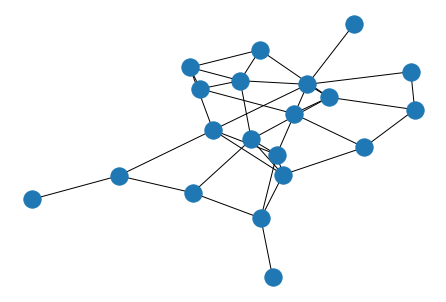

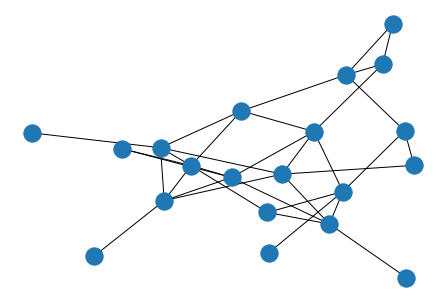

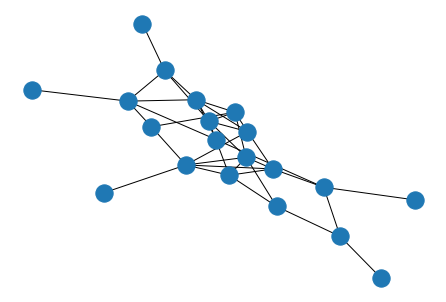

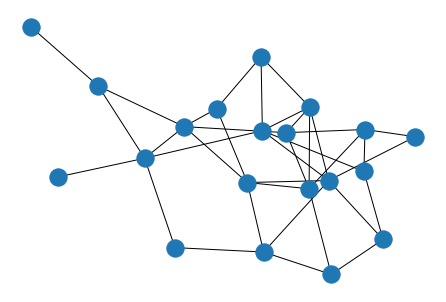

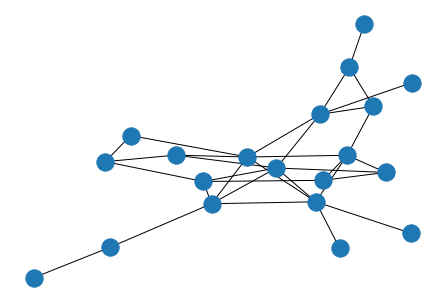

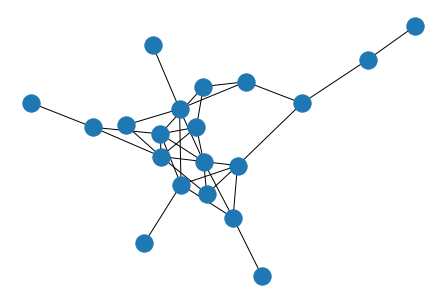

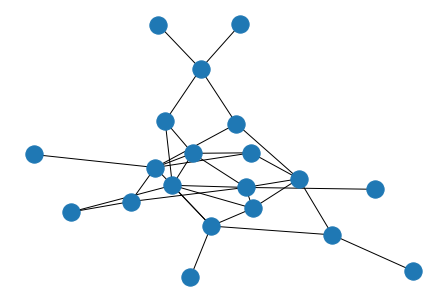

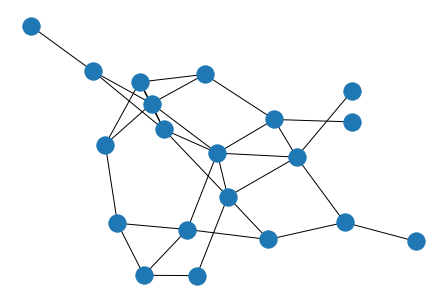

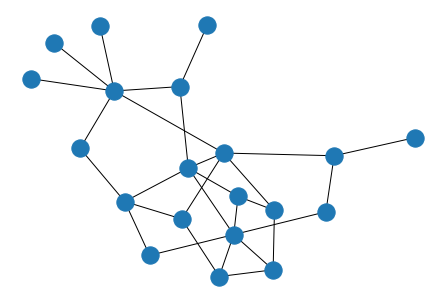

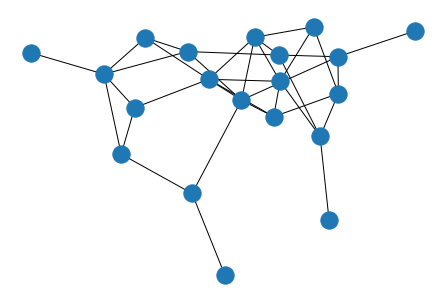

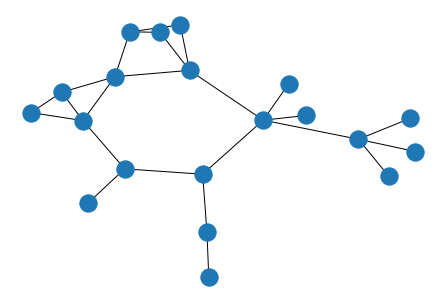

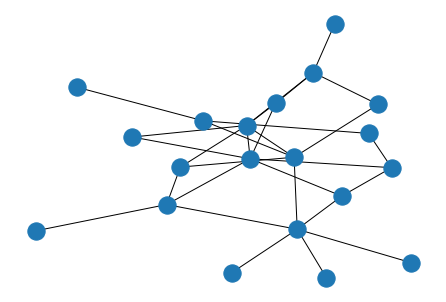

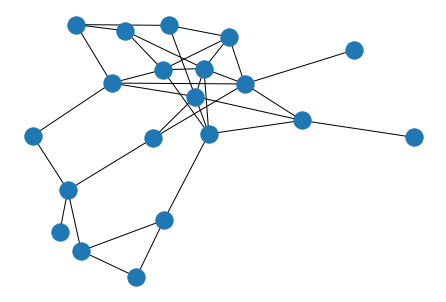

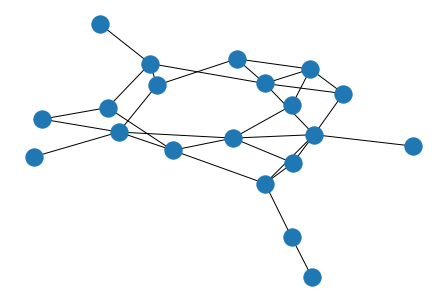

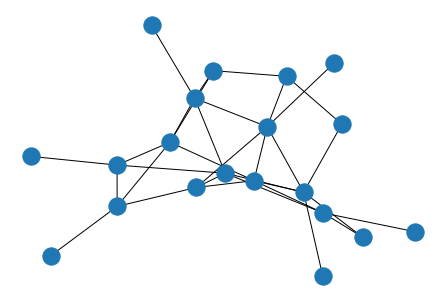

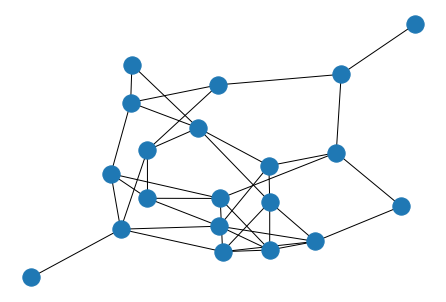

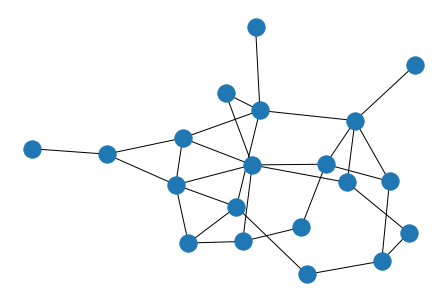

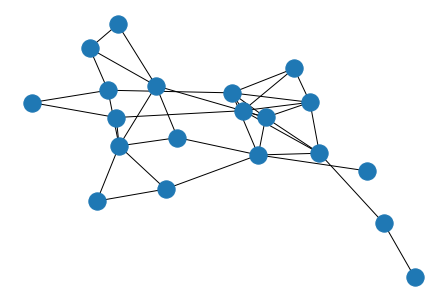

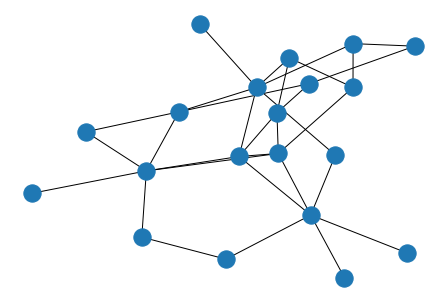

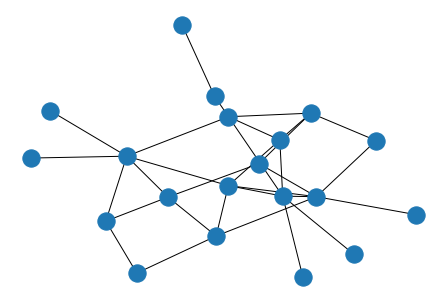

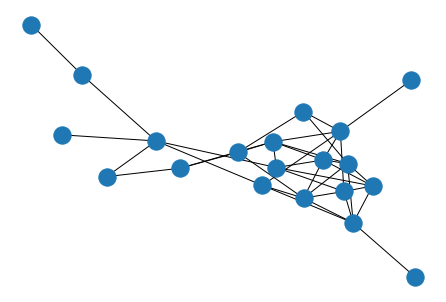

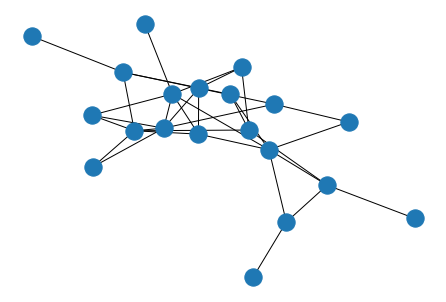

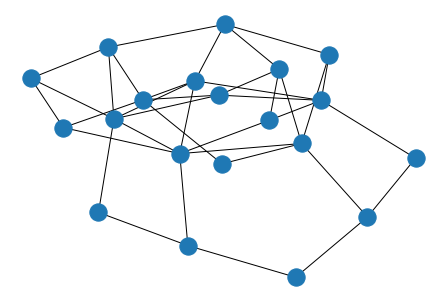

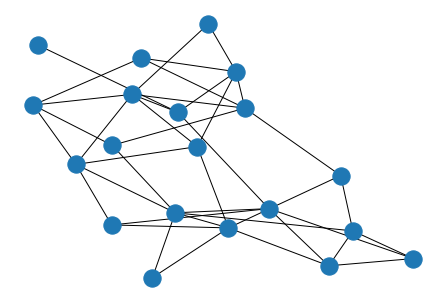

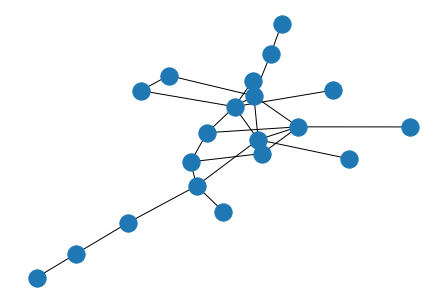

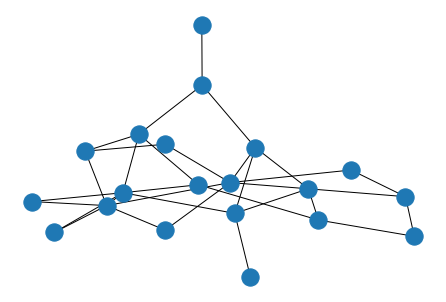

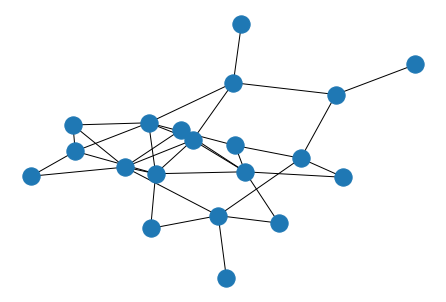

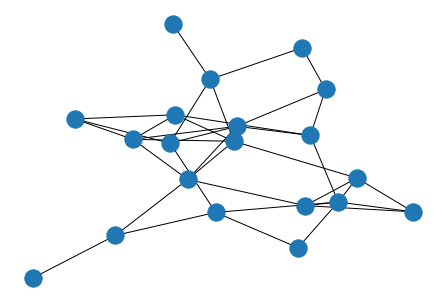

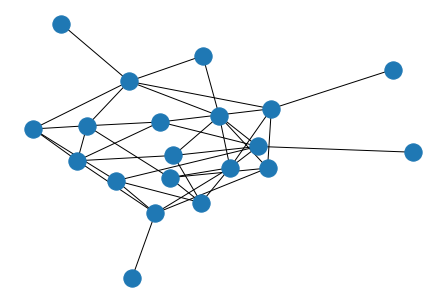

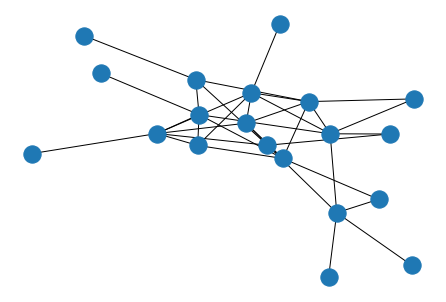

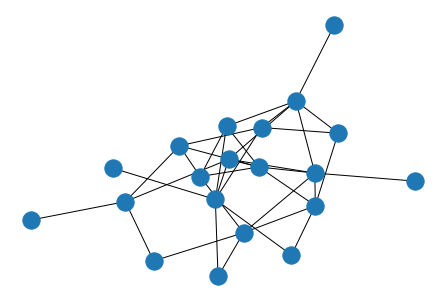

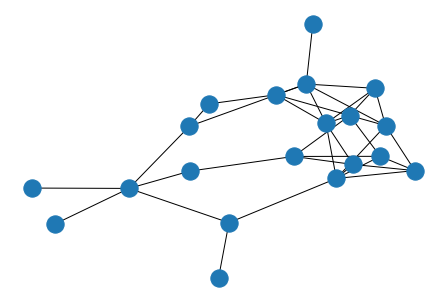

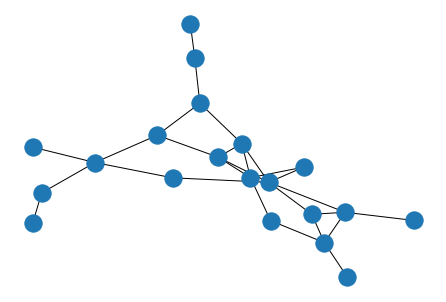

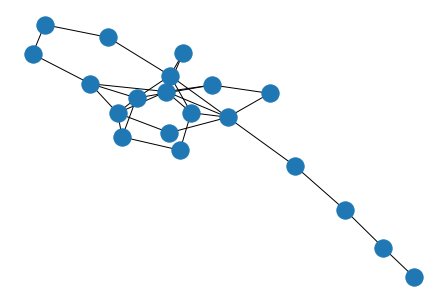

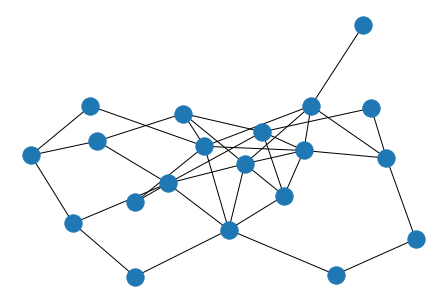

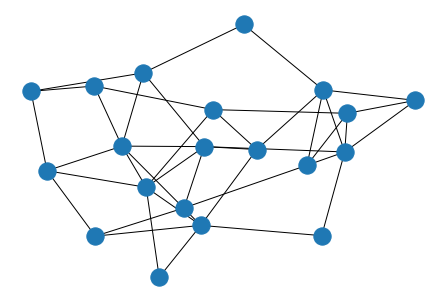

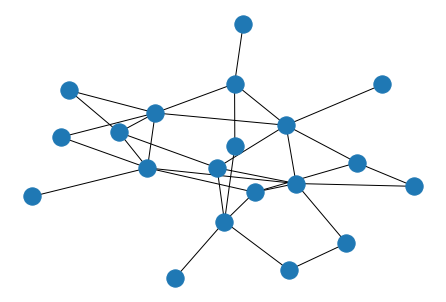

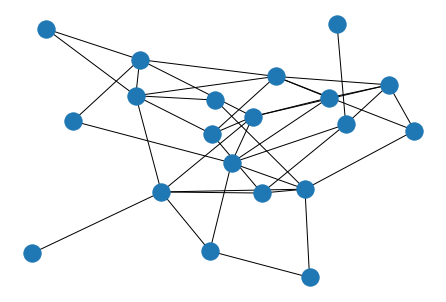

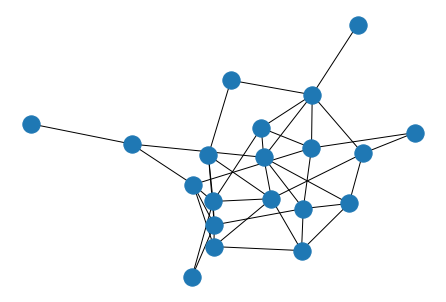

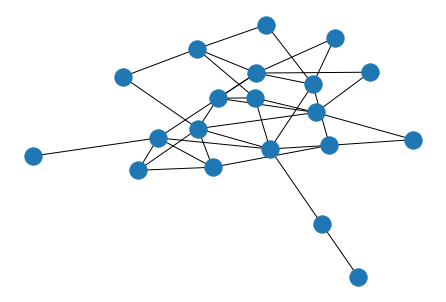

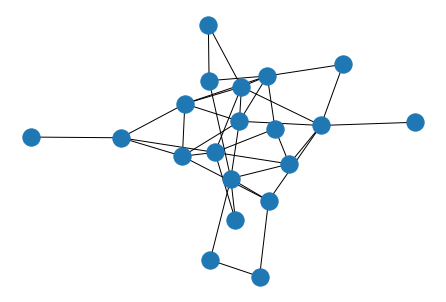

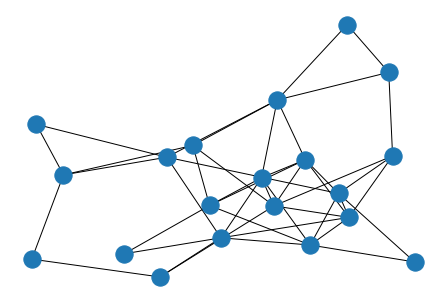

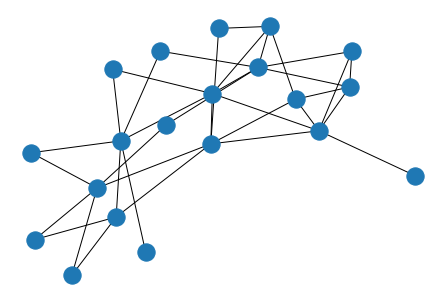

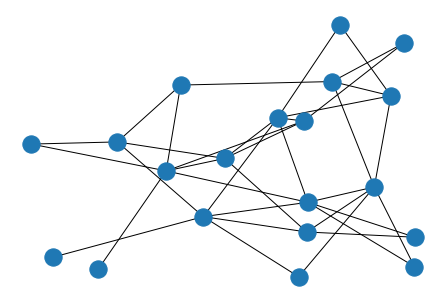

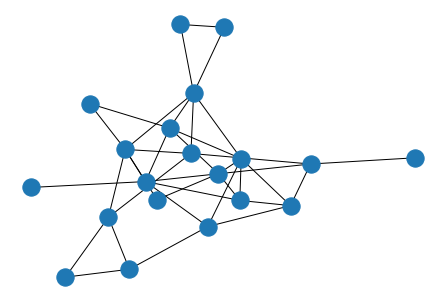

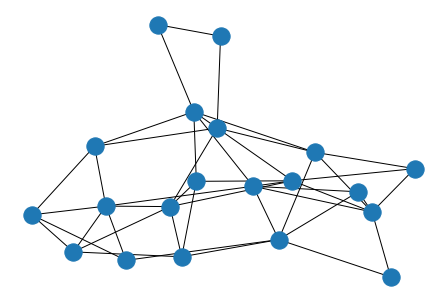

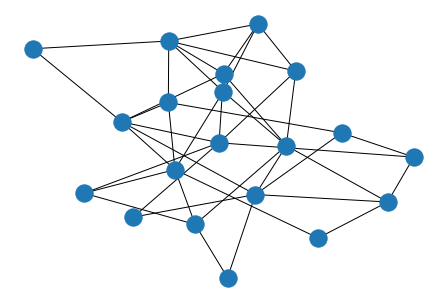

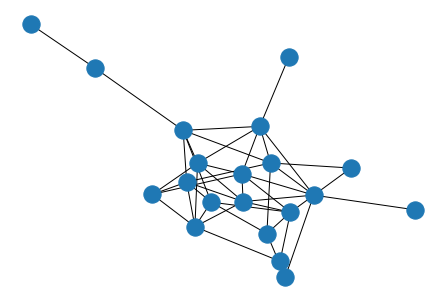

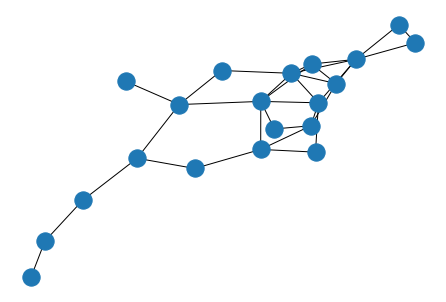

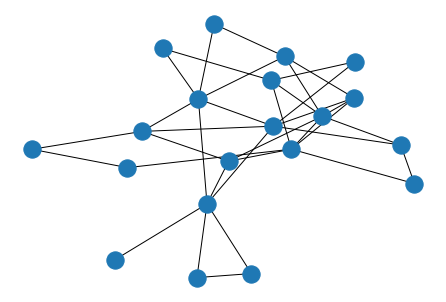

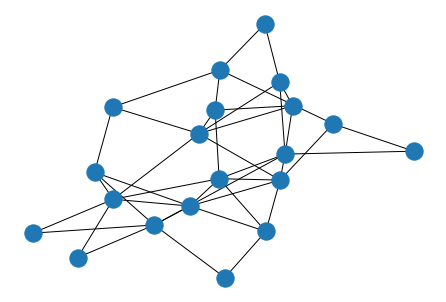

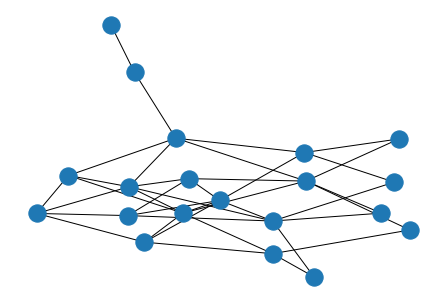

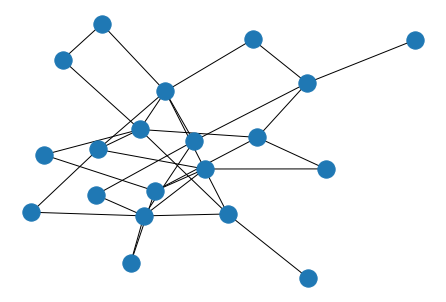

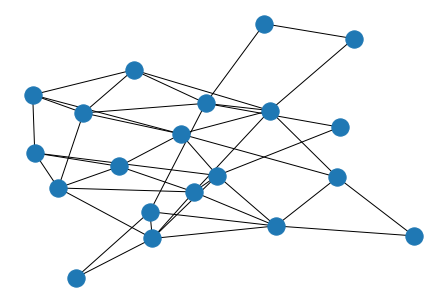

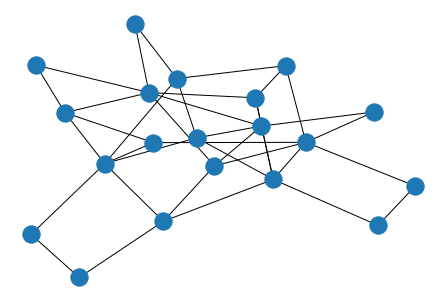

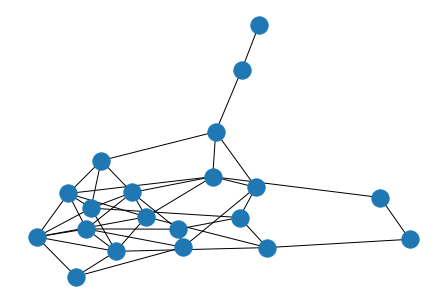

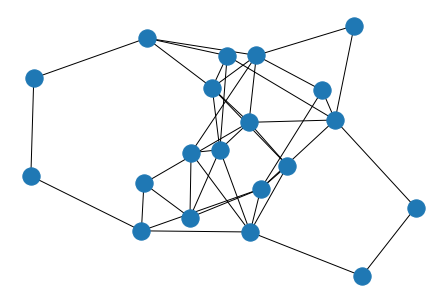

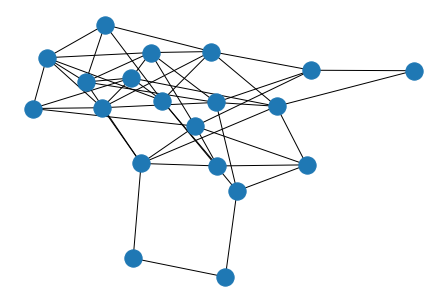

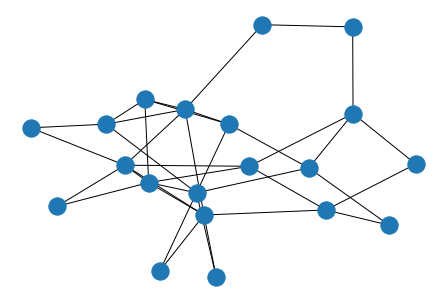

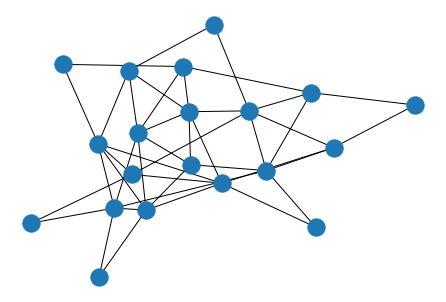

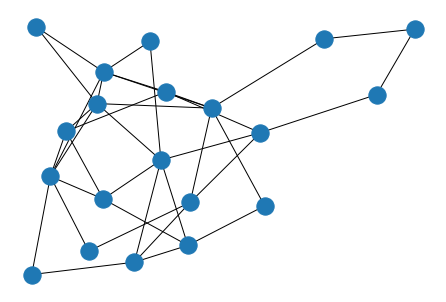

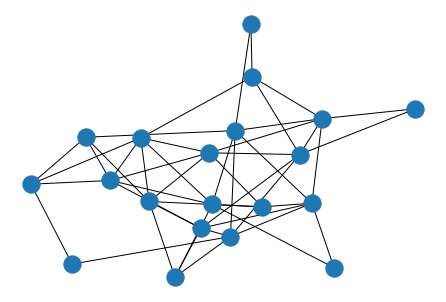

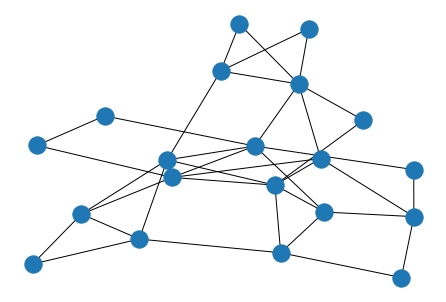

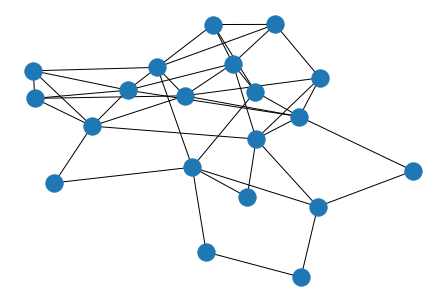

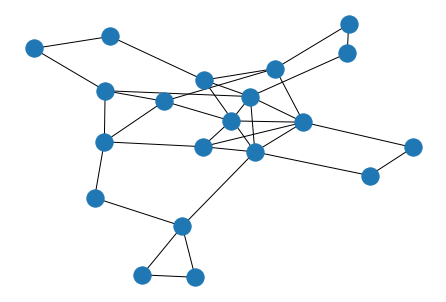

In [19]:
for g in n_g_list:
    nx.draw(g)
    plt.show()

#### Storing these graphs

In [20]:

def graphs_to_matrix(g_list):
  """
  Converts graphs to matrices
  """
  mat_list = []
  for g in g_list:
    mat = nx.linalg.graphmatrix.adj_matrix(g, weight = None)
    mat = scipy.sparse.csr_matrix.toarray(mat)
    mat_list.append(np.copy(mat))
  return mat_list

In [21]:
new_mat_list = graphs_to_matrix(n_g_list)

Storing in textfile

In [22]:
a_file = open("New20NodeRandomGraphs.txt", "w")
for mat in new_mat_list:
    for row in mat:
        np.savetxt(a_file, row)
a_file.close()

# checking if the new deg seqs are really distinct from old and from themselves

In [23]:
for deg_seq in new_deg_seqs:
    old_deg_seqs.remove(deg_seq)
for deg_seq in new_deg_seqs:
    if deg_seq in old_deg_seqs:
        print("something is wrong")

In [26]:
biny = []
for deg_seq in new_deg_seqs:
    if deg_seq not in biny:
        biny.append(deg_seq)
print(len(biny))

88
